In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import quantity_support

import synthesizAR
from synthesizAR.interfaces.ebtel import EbtelInterface, read_xml
from synthesizAR.models.heating import b_over_l_scaling

## Hydrodynamic Simulations with EBTEL

Parameterize heating using the approach of Warren et al. (2020).
Calculate a steady heating rate using a $B/L$ scaling and then model time-dependent heating as a Poisson process.

In [26]:
pathlib.Path.cwd().parent.stem

'sphere-workshop-2023-talk'

In [2]:
class PoissonHeating:
    """
    Implement time-dependent heating approach of Warren et al. (2020)
    """
    
    @u.quantity_input
    def __init__(self, total_time: u.s, p, alpha, duration: u.s, interval=1*u.s):
        """
        total_time
            Total simulation time
        p
            Finite probabiltiy of an event occuring per unit time
        alpha
            Power-law index of the event energy distribution
        duration
            Duration of each heating event
        interval
            Interval to sample when sampling the Poisson distribution of events
        """
        self.total_time = total_time
        self.p = p
        self.alpha = alpha
        self.duration = duration
        self.interval = interval
    
    def get_steady_heating_rate(self, loop)->u.Unit('erg cm-3 s-1'):
        # These parameters will give approximately a DEM centered on 3-4 MK
        return b_over_l_scaling(loop, H_0=8.77e-3*u.Unit('erg cm-3 s-1'),
                                B_0=76*u.G,
                                L_0=29*u.Mm,
                                alpha=0.2,
                                beta=1.0)
    
    def calculate_event_properties(self, loop):
        n_time = int(np.ceil((self.total_time / self.interval).decompose()))
        num_events = np.random.poisson(lam=self.p, size=n_time)
        event_happened = np.where(num_events>0)[0]
        waiting_times = np.diff(np.append(-1, event_happened)) * self.interval
        # We multiply by the number of events and assume that events which happen within a given
        # interval are of the same magnitude and thus add. To avoid this, you can shorten the interval
        # such that the number of events per interval is always 0 or 1. 
        heating_rates = np.exp(self.p * (waiting_times / self.interval).decompose() / self.alpha) # * num_events[event_happened]
        # Normalize the heating rate
        steady_heating_rate = self.get_steady_heating_rate(loop)
        norm = steady_heating_rate * self.total_time / (self.duration/2*heating_rates.sum())
        heating_rates *= norm
        # Set up event times
        start_rise_times = event_happened * self.interval
        end_rise_times = start_rise_times + self.duration/2
        start_decay_times = start_rise_times + self.duration/2
        end_decay_times = start_rise_times + self.duration
        return {
            'magnitude': heating_rates.to_value('erg cm-3 s-1'),
            'rise_start': start_rise_times.to_value('s'),
            'rise_end': end_rise_times.to_value('s'),
            'decay_start': start_decay_times.to_value('s'),
            'decay_end': end_decay_times.to_value('s'),
        }


In [3]:
ebtel_directory = '/Users/wtbarnes/Documents/codes/ebtelPlusPlus/'

In [4]:
ebtel_config = read_xml('/Users/wtbarnes/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')

In [5]:
event_duration = 200 * u.s
simulation_time = 3e4 * u.s
sampling_interval = 10 * u.s

In [6]:
ebtel_config['total_time'] = simulation_time.to_value('s')
ebtel_config['use_flux_limiting'] = True
ebtel_config['saturation_limit'] = 1/6
ebtel_config['use_adaptive_solver'] = True
ebtel_config['heating']['background'] = 1e-6

In [7]:
ebtel_config

{'total_time': 30000.0,
 'tau': 1.0,
 'tau_max': 1e+300,
 'loop_length': 4000000000.0,
 'saturation_limit': 0.16666666666666666,
 'force_single_fluid': False,
 'use_c1_loss_correction': True,
 'use_c1_grav_correction': True,
 'use_flux_limiting': True,
 'calculate_dem': False,
 'save_terms': False,
 'use_adaptive_solver': True,
 'output_filename': 'ebtel++_results_file.txt',
 'adaptive_solver_error': 1e-06,
 'adaptive_solver_safety': 0.5,
 'c1_cond0': 2.0,
 'c1_rad0': 0.6,
 'helium_to_hydrogen_ratio': 0.075,
 'surface_gravity': 1.0,
 'dem': OrderedDict([('use_new_method', True),
              ('temperature', {'bins': 451, 'log_min': 4, 'log_max': 8.5})]),
 'heating': OrderedDict([('background', 1e-06),
              ('partition', 1.0),
              ('events',
               [{'event': {'magnitude': 0.1,
                  'rise_start': 0.0,
                  'rise_end': 50.0,
                  'decay_start': 50.0,
                  'decay_end': 100.0}},
                {'event': {'magn

From some brief experimentation, $p=0.0005$ events per second are more akin to low-frequency heating (for an AR loop) while $p=0.01$ events per second gives rise to high-frequency heating.
This of course is loop dependent, i.e. what corresponds to low- versus high-frequency heating.

In [8]:
heating_high_frequency = PoissonHeating(simulation_time, 0.30, 2, event_duration, interval=sampling_interval)
heating_low_frequency = PoissonHeating(simulation_time, 0.01, 2, event_duration, interval=sampling_interval)

In [9]:
ebtel_high_frequency = EbtelInterface(ebtel_config, heating_high_frequency, ebtel_directory)
ebtel_low_frequency = EbtelInterface(ebtel_config, heating_low_frequency, ebtel_directory)

In [10]:
skeleton_high_frequency = synthesizAR.Skeleton.from_asdf('../data/simulations/skeleton.asdf')

In [11]:
skeleton_high_frequency.load_loop_simulations(ebtel_high_frequency, filename='../data/simulations/high_frequency_heating.asdf')

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [12]:
skeleton_low_frequency = synthesizAR.Skeleton.from_asdf('../data/simulations/skeleton.asdf')

In [13]:
skeleton_low_frequency.load_loop_simulations(ebtel_low_frequency, filename='../data/simulations/low_frequency_heating.asdf')

Text(0.5, 0.98, 'High-frequency Heating')

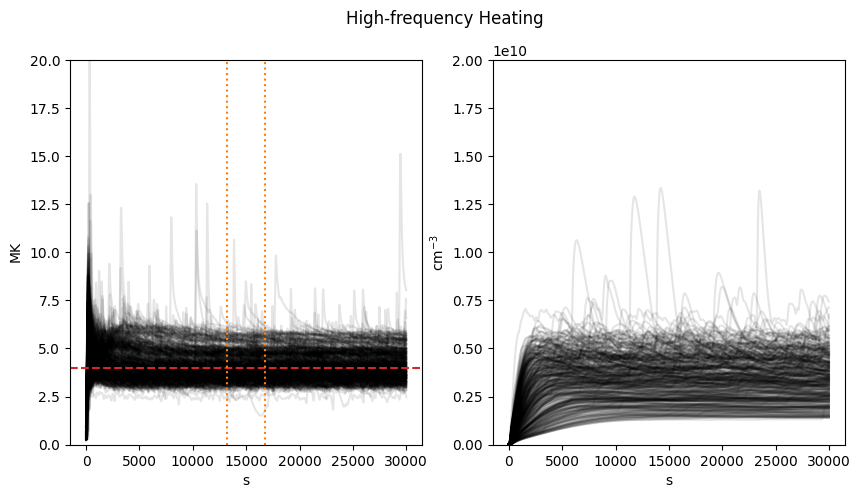

In [14]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
with quantity_support():
    for l in skeleton_high_frequency.loops[::2]:
        ax[0].plot(l.time, l.electron_temperature[:,0].to("MK"), color='k', alpha=0.1)
        ax[1].plot(l.time, l.density[:,0], color='k', alpha=0.1)
ax[0].axhline(y=4, ls='--', color='C3')
dt = 1*u.h
ax[0].axvline(x=(simulation_time/2 - dt/2).to_value('s'), ls=':', color='C1')
ax[0].axvline(x=(simulation_time/2 + dt/2).to_value('s'), ls=':', color='C1')
ax[0].set_ylim(0,20)
ax[1].set_ylim(0, 2e10)
fig.suptitle('High-frequency Heating')

Text(0.5, 0.98, 'Low-frequency Heating')

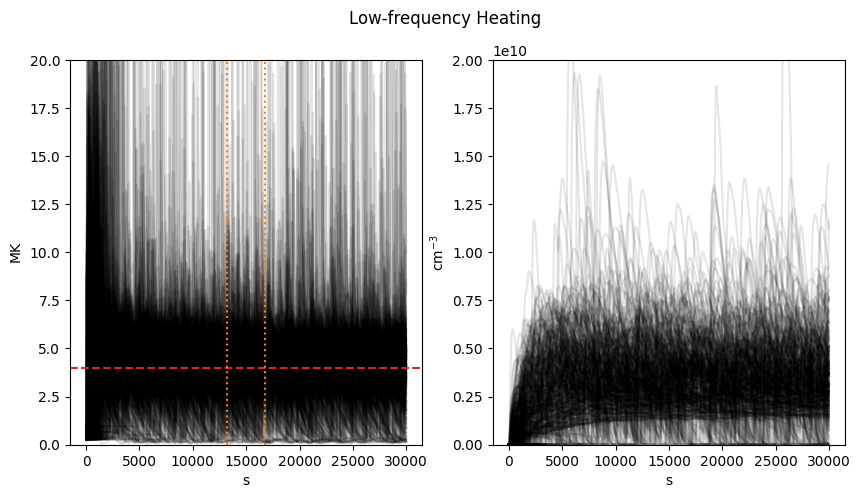

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
with quantity_support():
    for l in skeleton_low_frequency.loops[::2]:
        ax[0].plot(l.time, l.electron_temperature[:,0].to("MK"), color='k', alpha=0.1)
        ax[1].plot(l.time, l.density[:,0], color='k', alpha=0.1)
ax[0].axhline(y=4, ls='--', color='C3')
ax[0].axvline(x=(simulation_time/2 - dt/2).to_value('s'), ls=':', color='C1')
ax[0].axvline(x=(simulation_time/2 + dt/2).to_value('s'), ls=':', color='C1')
ax[0].set_ylim(0,20)
ax[1].set_ylim(0, 2e10)
fig.suptitle('Low-frequency Heating')

In [16]:
skeleton_high_frequency.to_asdf('../data/simulations/skeleton_high_frequency.asdf')

In [17]:
skeleton_low_frequency.to_asdf('../data/simulations/skeleton_low_frequency.asdf')